In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn import metrics

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing Training Set
dataset_train = pd.read_csv('/content/drive/MyDrive/CSE_438 Project/Dataset/Dataset3.csv')
# dataset_train.drop(["Unnamed: 0"],axis = 1)
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (2006, 7)
All timestamps == 2006
Featured selected: ['Open', 'High', 'Low', 'Close*', 'Adj Close**']


In [4]:
test=dataset_train.iloc[239:]['Open']
print(test)

239      4534.50
240      4571.50
241      4607.50
242      4656.75
243      4577.00
          ...   
2001    12000.50
2002    11812.00
2003    11566.00
2004    11500.00
2005    11641.50
Name: Open, Length: 1767, dtype: float64


In [5]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (2006, 5).


array([[ 4240.25,  4272.75,  4201.  ,  4214.25,  4214.25],
       [ 4216.  ,  4220.75,  4145.  ,  4161.75,  4161.75],
       [ 4166.5 ,  4172.5 ,  4082.  ,  4102.25,  4102.25],
       ...,
       [11566.  , 11596.25, 11422.5 , 11509.5 , 11509.5 ],
       [11500.  , 11685.75, 11433.  , 11645.5 , 11645.5 ],
       [11641.5 , 11748.  , 11517.  , 11569.75, 11569.75]])

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.12961762],
       [-1.13627479],
       [-1.14986365],
       ...,
       [ 0.8814655 ],
       [ 0.86334702],
       [ 0.90219195]])

In [7]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1857, 90, 4).
y_train shape == (1857, 1).


In [32]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 90, 50)            8400      
                                                                 
 dropout_24 (Dropout)        (None, 90, 50)            0         
                                                                 
 gru_25 (GRU)                (None, 90, 50)            15300     
                                                                 
 dropout_25 (Dropout)        (None, 90, 50)            0         
                                                                 
 gru_26 (GRU)                (None, 90, 50)            15300     
                                                                 
 dropout_26 (Dropout)        (None, 90, 50)            0         
                                                                 
 gru_27 (GRU)                (None, 90, 50)           

In [33]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=150, batch_size=300)

Epoch 1/150
7/7 [==============================] - 10s 522ms/step - loss: 0.3526
Epoch 2/150
7/7 [==============================] - 4s 520ms/step - loss: 0.1154
Epoch 3/150
7/7 [==============================] - 4s 524ms/step - loss: 0.0958
Epoch 4/150
7/7 [==============================] - 4s 515ms/step - loss: 0.0855
Epoch 5/150
7/7 [==============================] - 4s 529ms/step - loss: 0.0740
Epoch 6/150
7/7 [==============================] - 4s 517ms/step - loss: 0.0779
Epoch 7/150
7/7 [==============================] - 4s 517ms/step - loss: 0.0730
Epoch 8/150
7/7 [==============================] - 4s 511ms/step - loss: 0.0716
Epoch 9/150
7/7 [==============================] - 4s 518ms/step - loss: 0.0712
Epoch 10/150
7/7 [==============================] - 4s 517ms/step - loss: 0.0713
Epoch 11/150
7/7 [==============================] - 4s 519ms/step - loss: 0.0668
Epoch 12/150
7/7 [==============================] - 4s 515ms/step - loss: 0.0680
Epoch 13/150
7/7 [==================

In [34]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()


# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [35]:
# Perform predictions
predictions_future = modelGRU.predict(X_train[-n_future:])

predictions_train = modelGRU.predict(X_train[n_past:])

56/56 [==============================] - 2s 31ms/step


In [36]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
   
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2015-12-14,4845.729980
2015-12-15,4851.107422
2015-12-16,4852.802734


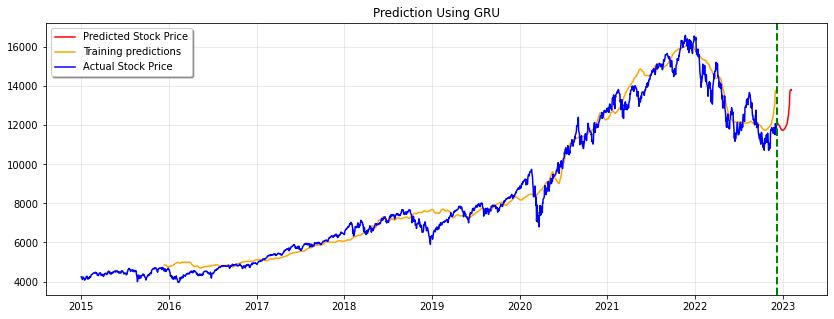

In [37]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2015-08-28'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(datelist_train, dataset_train['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title("Prediction Using GRU")
plt.show()


In [38]:
pred = np.array(PREDICTION_TRAIN["Open"])
diff = pred - test
diffLSTM=list(diff)[1:]
diffLSTM=np.array(diffLSTM)
print("MSE:", np.mean(diffLSTM**2))
print("MAE:", np.mean(abs(diffLSTM)))
print("RMSE:", np.sqrt(np.mean(diffLSTM**2)))

MSE: 282879.97331544675
MAE: 400.9882605132538
RMSE: 531.8646193491787


In [39]:
pred=[]
for val in PREDICTION_TRAIN['Open']:
  pred.append(val)
for i in range(len(pred)):
  pred[i]=int(pred[i])

testValues=[]
for val in test:
  testValues.append(float(val))

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

print('MSE: ',np.sqrt(mean_squared_error(testValues, pred)))
print("Mean Absolute Error: ",mean_absolute_error(testValues, pred))
print("R2 Score: ",r2_score(testValues, pred))
print("MAPE Percentage Error: ",mean_absolute_percentage_error(testValues, pred))

MSE:  531.6756208741554
Mean Absolute Error:  400.9248726655348
R2 Score:  0.977718931357642
MAPE Percentage Error:  0.049014507460116055
